In [ ]:
!pip install tensorflow opencv-python matplotlib numpy tqdm scikit-image


^C



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\madhu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached numpy-2.2.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached protobuf-5.29.3-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached setuptools-75.8.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
 

In [1]:
import tensorflow as tf

dataset_path = "processed_dataset"
train_dir = "train_data"
val_dir = "val_data"
test_dir = "test_data"

# Set parameters
BATCH_SIZE = 8
IMG_SIZE = (224, 224)  # ResNet50 input size
AUTOTUNE = tf.data.AUTOTUNE

# Load train, validation, and test datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

# Normalize pixel values (0-255 → 0-1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

# Optimize data loading performance
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print("✅ Dataset successfully loaded and normalized!")


Found 454 files belonging to 2 classes.
Found 115 files belonging to 2 classes.
Found 569 files belonging to 2 classes.
✅ Dataset successfully loaded and normalized!


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load ResNet50 base model (without top layers)
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze the base model to retain pretrained features
base_model.trainable = False

# Define the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),  # Regularization
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")  # Binary classification (Sickle Cell: Yes/No)
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    validation_split=0.2  # 20% of data for validation
)

# Paths
train_dir = "train_data"  # Update this if needed

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode="binary",
    subset="training"
)

# Validation Data Generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)


Found 364 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [29]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU, force CPU usage

import tensorflow as tf
print("Using CPU:", tf.config.list_physical_devices('GPU') == [])  # Should print True


Using CPU: False


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop training if no improvement after 5 epochs
    restore_best_weights=True
)

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(
    "best_model.h5",  # File to save the best model
    monitor='val_loss',
    save_best_only=True,  # Save only the best performing model
    mode='min'            # Minimize validation loss
)

print("Callbacks defined successfully!")


Callbacks defined successfully!


In [7]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stopping, model_checkpoint],
    max_queue_size=10,  # Reduce memory usage
)


Epoch 1/25
46/46 [==============================] - 130s 3s/step - loss: 0.6254 - accuracy: 0.6758 - val_loss: 0.5667 - val_accuracy: 0.7444
Epoch 2/25
46/46 [==============================] - 68s 1s/step - loss: 0.6324 - accuracy: 0.7088 - val_loss: 0.5575 - val_accuracy: 0.7444
Epoch 3/25
46/46 [==============================] - 67s 1s/step - loss: 0.5945 - accuracy: 0.7060 - val_loss: 0.5407 - val_accuracy: 0.7444
Epoch 4/25
46/46 [==============================] - 68s 1s/step - loss: 0.5909 - accuracy: 0.7253 - val_loss: 0.5284 - val_accuracy: 0.7778
Epoch 5/25
46/46 [==============================] - 67s 1s/step - loss: 0.5765 - accuracy: 0.7445 - val_loss: 0.5445 - val_accuracy: 0.7556
Epoch 6/25
46/46 [==============================] - 68s 1s/step - loss: 0.5739 - accuracy: 0.7253 - val_loss: 0.5228 - val_accuracy: 0.7444
Epoch 7/25
46/46 [==============================] - 67s 1s/step - loss: 0.5623 - accuracy: 0.7418 - val_loss: 0.5496 - val_accuracy: 0.7444
Epoch 8/25
46/46 [=

In [25]:
import tensorflow as tf

# Check available devices
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Check which device TensorFlow is using
tf.debugging.set_log_device_placement(True)


TensorFlow version: 2.10.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Define a test data generator (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test images
test_dir = "test_data"  # Update if needed
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Found 569 images belonging to 2 classes.
18/18 [==============================] - 96s 5s/step - loss: 0.4328 - accuracy: 0.8295
Test Accuracy: 82.95%
Test Loss: 0.4328


In [9]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)

# Print test evaluation metrics
print(f"🔍 Test Accuracy: {test_acc * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


18/18 [==============================] - 79s 4s/step - loss: 0.4328 - accuracy: 0.8295
🔍 Test Accuracy: 82.95%
📉 Test Loss: 0.4328


18/18 [==============================] - 312s 18s/step
🔎 Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.73      0.69       147
    Positive       0.90      0.86      0.88       422

    accuracy                           0.83       569
   macro avg       0.78      0.80      0.79       569
weighted avg       0.84      0.83      0.83       569



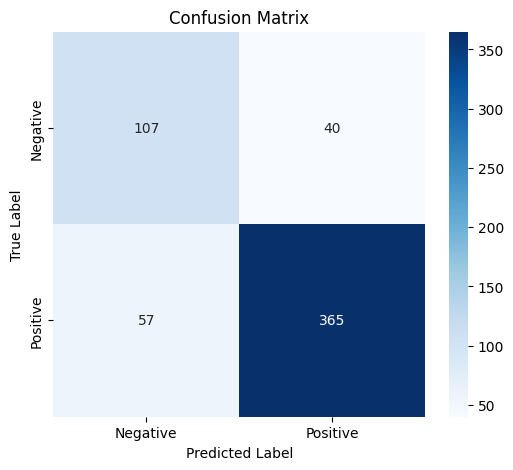

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels
true_labels = test_generator.classes

# Predict labels
predictions = model.predict(test_generator)
pred_labels = (predictions > 0.5).astype("int").flatten()

# Print classification report
print("🔎 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


1/1 [==============================] - 0s 74ms/step


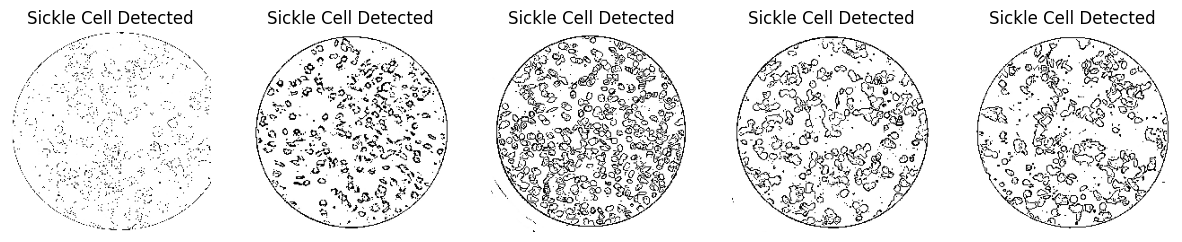

In [12]:
import random
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to the unlabeled folder
unlabeled_path = os.path.join("processed_dataset", "Positive", "Unlabelled")

# Get random images
random_images = random.sample(os.listdir(unlabeled_path), 5)  # Pick 5 random images

plt.figure(figsize=(15, 5))

for i, img_name in enumerate(random_images):
    img_path = os.path.join(unlabeled_path, img_name)
    
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to model input size
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Predict
    prediction = model.predict(img_array)
    predicted_label = "Sickle Cell Detected" if prediction > 0.5 else "Normal RBC"
    
    # Display Image with Prediction
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(predicted_label)
    plt.axis("off")

plt.show()


In [13]:
# Make prediction
prediction = model.predict(img_array)
predicted_label = "Sickle Cell Detected (Positive)" if prediction > 0.5 else "Normal RBC (Negative)"

# Display result
print(f"🔍 Model Prediction: {predicted_label} (Confidence: {prediction[0][0] * 100:.2f}%)")


1/1 [==============================] - 0s 93ms/step
🔍 Model Prediction: Sickle Cell Detected (Positive) (Confidence: 56.79%)


In [14]:
# Save the entire model
model.save("resnet50_sickle_cell_model.h5")

print("✅ Model saved successfully as resnet50_sickle_cell_model.h5")


✅ Model saved successfully as resnet50_sickle_cell_model.h5
